## 3. Example Driven

## Introduction

Such approaches explain the prediction of an input instance by identifying and presenting other instances, usually from available labeled data, that are semantically similar to the input instance.

The paper proposes, among other examples: [Auditing Deep Learning processes through Kernel-based Explanatory Models](https://aclanthology.org/D19-1415.pdf).
* The author of this project tried to clone and use the library, however it is notably outdated (some libraries have long-deprecated features and the code has not been adapted), there is very few information in the ReadMe on the usage (after having updated the code by hand with the outdated libraries, the server coudl be loaded locally, but it required a user and a password, that is hardcoded in the source of the project). Even so after bypassing these problems, the server did not load anymore; so this method was desestimated for this project due to its lack of mainteinance.

## Experiments

To exemplify this method, we propose a variation of [Understanding neural networks through representation erasure](https://arxiv.org/pdf/1612.08220.pdf). In the paper, they evaluate the importance of a dimension of a feature by deleting it and comparing how that affects to the loglikelihood of the prediction.
They propose the following metric:


$S(e,c,\neg d): I(d) = \dfrac{1}{|E|} \displaystyle\sum_{e\in E} \dfrac{S(e,c) - S(e,c,\neg d)}{S(e,c)}$

Where:
* $e$ : training example
* $c$ : the class where e belongs to (ground truth).
* $S(e, c)$ : log-likelihood assigned by model M to the correct label for e $(−log P(L_e = c)$.
* $L_e$ : label assigned to example $e$ by the classification algorithm.
* $S(e, c, ¬d)$ : denote the log-likelihood of the correct label for $e$ according to $M$ if dimension d is erased
* $I(d)$ : importance of $d$

## Experiments

The original paper uses the metric to test the relevance of the embeddings dimension and computes it using all the training set. We can tweak a bit this metric to make it example driven.
For a given sentence that we want, we will apply the erasure score with the words that form the sentence and see how much the word affects to the final logits.


To test our proposed approach, we will take our pretrained model and input a sentence of our test. We will erase different words from the input sentence and evaluate its importance according the metric proposed by Li et al.

In [20]:
# Uncomment this to finetune the model!
# it takes a while, so it is commented to avoid re-doing the same several times

# !python3 src/finetune.py

In [21]:
from transformers import AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer
from src.preprocess import get_train_dev_test_data

import plotly.figure_factory as ff
import plotly.io as pio

pio.renderers.default = "notebook_connected"

In [22]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained(
    "pretrained_model/", num_labels=4
)

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [23]:
_, _, test = get_train_dev_test_data()
labels = ["negative", "positive", "neutral", "mixed"]

sample = test[32]

In [24]:
sample

{'verse_text': 'And you held my lifeless frame', 'labels': 0}

In [25]:
pipe(sample["verse_text"], return_all_scores=True)

/Users/mariaribalta/Documents/EHU/DeepLearning/FinalProject/venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:105: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



[[{'label': 'LABEL_0', 'score': 0.9870206713676453},
  {'label': 'LABEL_1', 'score': 0.0008933398639783263},
  {'label': 'LABEL_2', 'score': 0.00396553473547101},
  {'label': 'LABEL_3', 'score': 0.008120451122522354}]]

In [26]:
def compute_classification_scores(sentence, pipe):
    split_sentence = sentence.split(" ")
    original_sentence_score = pipe(sentence, top_k=4)
    results_removed_word = dict()

    for idx in range(len(split_sentence)):
        removed_word_sentence = " ".join(
            split_sentence[:idx] + split_sentence[idx + 1 :]
        )
        score = pipe(removed_word_sentence, top_k=4)
        results_removed_word[removed_word_sentence] = sorted(
            score, key=lambda x: x["label"]
        )

    return (
        sorted(original_sentence_score, key=lambda x: x["label"]),
        results_removed_word,
    )

In [27]:
def compute_importance_score(original_sentence_score, results_removed_word):
    sentences = list(results_removed_word.keys())
    scores_matrix = []

    for word_idx in range(len(sentences)):
        scores_row = []
        for label_idx in range(4):
            current_score = results_removed_word[sentences[word_idx]][label_idx][
                "score"
            ]
            original_score = original_sentence_score[label_idx]["score"]

            scores_row.append((original_score - current_score) / original_score)
        scores_matrix.append(scores_row)

    return scores_matrix

In [28]:
sentence = sample["verse_text"]
split_sentence = sentence.split(" ")
original_sentence_score, results_removed_word = compute_classification_scores(
    sentence, pipe
)
scores_matrix = compute_importance_score(original_sentence_score, results_removed_word)

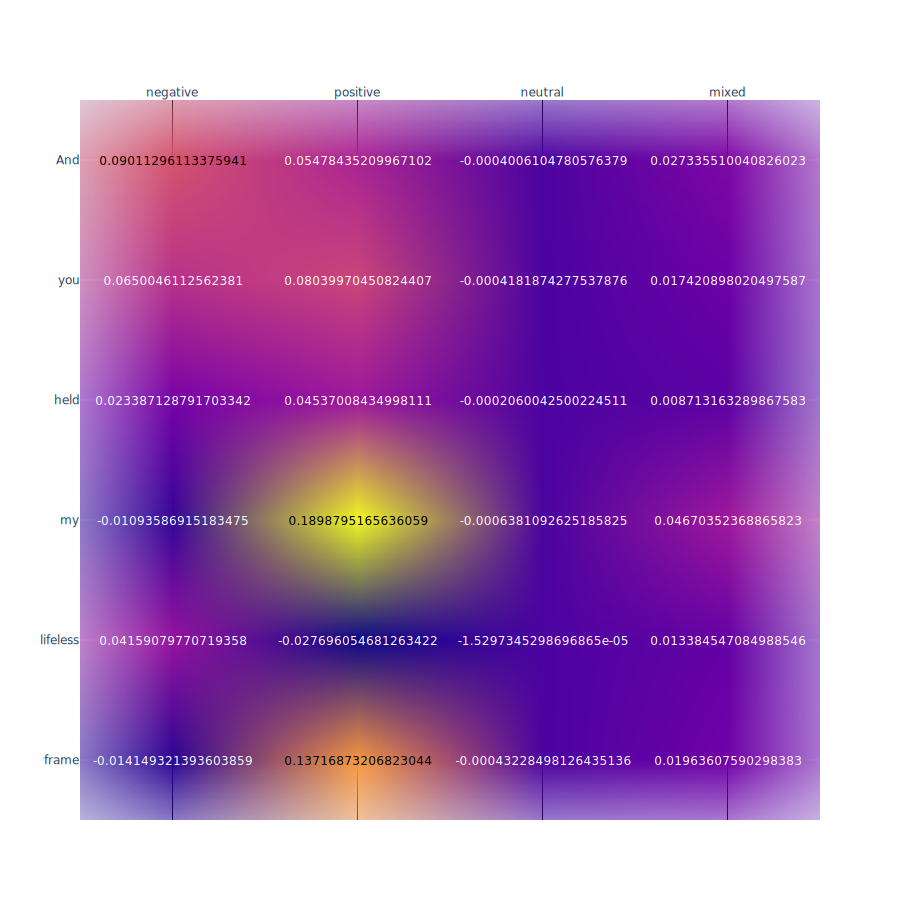

In [52]:
fig = ff.create_annotated_heatmap(scores_matrix, x=labels, y=split_sentence)

fig["layout"]["yaxis"]["autorange"] = "reversed"
fig.show(renderer="svg", width=900, height=900)

Now let's try with more examples and see which words are more relevant towards the decision of some classifications!
We will encapsulate the whole process in a function, to avoid repeating chunks of code:

In [55]:
def compute_scores_matrix(sample_nr):
    sentence = test[sample_nr]["verse_text"]
    split_sentence = sentence.split(" ")
    original_sentence_score, results_removed_word = compute_classification_scores(
        sentence, pipe
    )
    scores_matrix = compute_importance_score(
        original_sentence_score, results_removed_word
    )

    fig = ff.create_annotated_heatmap(scores_matrix, x=labels, y=split_sentence)
    fig["layout"]["yaxis"]["autorange"] = "reversed"
    fig.show(renderer="svg", width=900, height=900)

    return scores_matrix

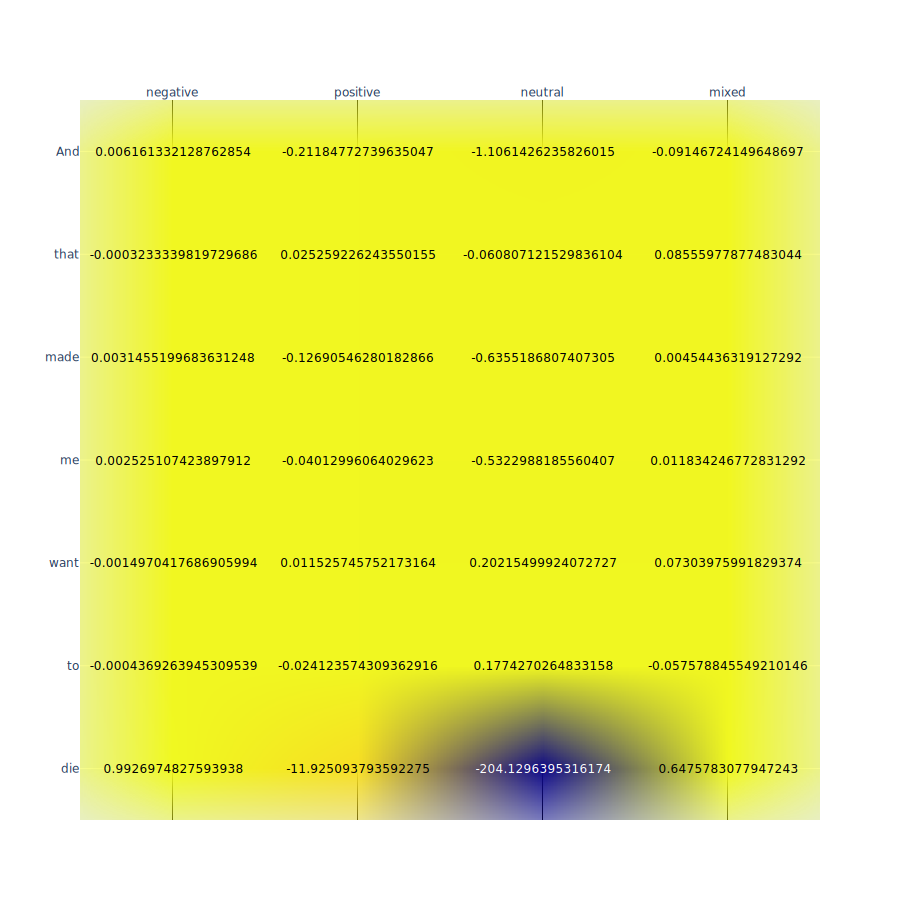

In [56]:
scores_matrix = compute_scores_matrix(59)

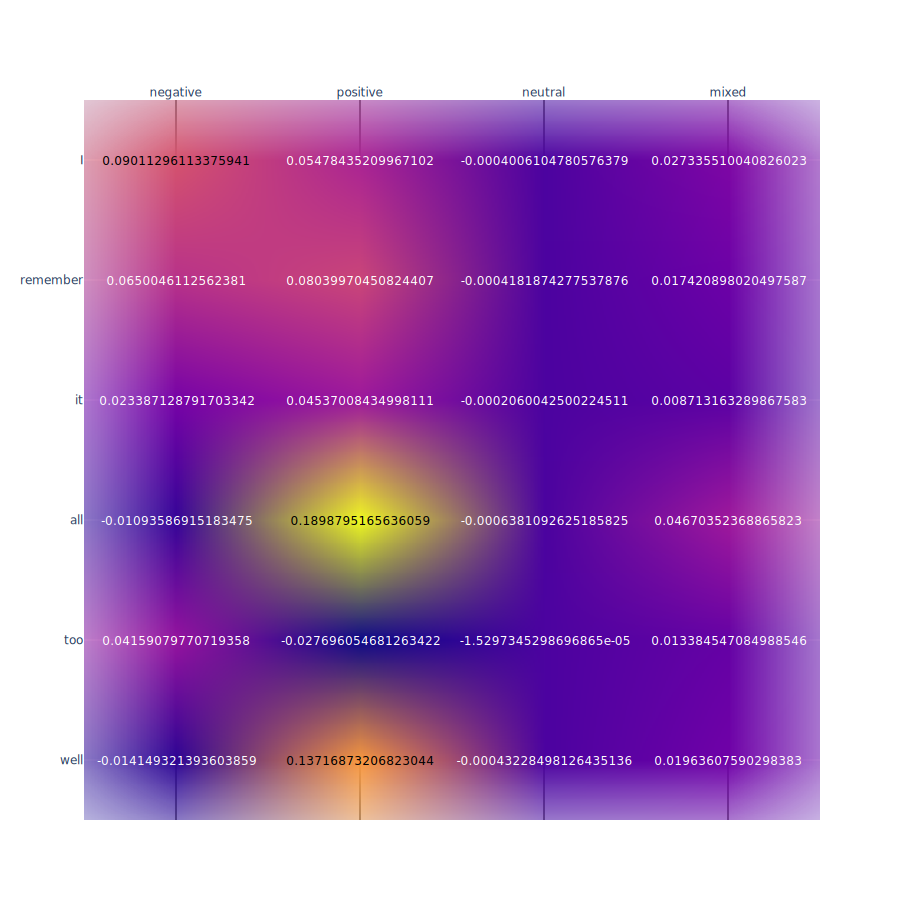

In [57]:
scores_matrix = compute_scores_matrix(100)